In [424]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [425]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [426]:
df = pd.read_csv('housing.csv')

In [427]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


/home/tom/.cache/pypoetry/virtualenvs/ml-zoomcamp-9FM8Shbn-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tom/.cache/pypoetry/virtualenvs/ml-zoomcamp-9FM8Shbn-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='median_house_value', ylabel='Count'>

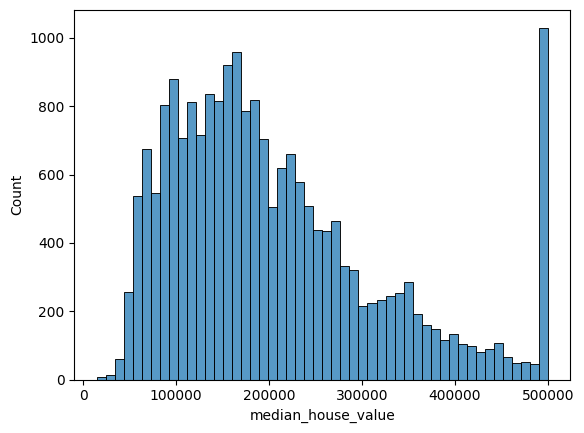

In [428]:
sns.histplot(df.median_house_value, bins=50)

In [429]:
#First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

df = df[
    (df.ocean_proximity == '<1H OCEAN') 
    | (df.ocean_proximity == 'INLAND')
]


In [430]:
base = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
]
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [431]:
# Next, use only the following columns:
# 'latitude',
# 'longitude',
# 'housing_median_age',
# 'total_rooms',
# 'total_bedrooms',
# 'population',
# 'households',
# 'median_income',
# 'median_house_value'

df = df[base]

In [432]:
###
# Question 1
# There's one feature with missing values. What is it?
###
df.isnull().sum()

# total_bedrooms


latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [433]:
####
# Question 2
# What's the median (50% percentile) for variable 'population'?
####
df.population.median()

# 1195.0

1195.0

In [434]:
### Prepare and split the dataset ###
# Shuffle the dataset (the filtered one you created above), use seed 42.
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
# Apply the log transformation to the median_house_value variable using the np.log1p() function.

# Shuffle
n =len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]



In [435]:
####
# Question 3
# We need to deal with missing values for the column from Q1.
# We have two options: fill it with 0 or with the mean of this variable.
# Try both options. For each, train a linear regression model without regularization using the code from the lessons.
# For computing the mean, use the training only!
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
# Round the RMSE scores to 2 decimal digits using round(score, 2)
# Which option gives better RMSE?
####


def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# FIRST
df_train_zeros = df_train.copy()
df_train_zeros["total_bedrooms"] = df_train_zeros['total_bedrooms'].fillna(0)
X_train_filled_zeros = df_train_zeros.values
print(X_train_filled_zeros.shape)

w0z, wz = train_linear_regression(X_train_filled_zeros, y_train)

df_val_zeros = df_val.copy()
df_val_zeros["total_bedrooms"] = df_val_zeros['total_bedrooms'].fillna(0)
X_val_zeros = df_val_zeros.values
y_pred_zeros = w0z + X_val_zeros.dot(wz)
rmse_zeros_val = rmse(y_val, y_pred_zeros)

# SECOND
df_train_mean = df_train.copy()
bedrooms_mean = df_train_mean.total_bedrooms.mean()
df_train_mean["total_bedrooms"] = df_train_mean['total_bedrooms'].fillna(bedrooms_mean)
X_train_filled_mean = df_train_mean.values

w0m, wm = train_linear_regression(X_train_filled_mean, y_train)

df_val_mean = df_val.copy()
df_val_mean["total_bedrooms"] = df_val_mean['total_bedrooms'].fillna(bedrooms_mean)
X_val_mean = df_val_mean.fillna(bedrooms_mean).values
y_pred_mean = w0m + X_val_mean.dot(wm)
rmse_mean_val = rmse(y_val, y_pred_mean)

print(round(rmse_zeros_val, 2), round(rmse_mean_val,2))  

# Doesn't differ, 0.34, 0.34



(9413, 8)
0.34 0.34


In [436]:
####
# Question 4
# Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.
# Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
# Which r gives the best RMSE?
# If there are multiple options, select the smallest r.
####

def prepare_X(df, fill_value):
    df = df.copy()
    df["total_bedrooms"] = df['total_bedrooms'].fillna(fill_value)
    X = df.values
    return X

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]


for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred).round(2)

    print(r, w0, score)


# 0

0 -9.763249477872478 0.34
1e-06 -9.763228830761964 0.34
0.0001 -9.761185235634128 0.34
0.001 -9.742646249295081 0.34
0.01 -9.56105619328998 0.34
0.1 -8.058889769412012 0.34
1 -3.1331542783180195 0.34
5 -0.84108679750481 0.35
10 -0.43811723158933275 0.35


In [443]:
####
# Question 5
# We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
# For each seed, do the train/validation/test split with 60%/20%/20% distribution.
# Fill the missing values with 0 and train a model without regularization.
# For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
# What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
# Round the result to 3 decimal digits (round(std, 3))
####
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

rmse_scores = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    X_train = prepare_X(df_train, 0)
    X_val = prepare_X(df_val, 0)

    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)
rmse_scores
round(np.std(rmse_scores), 3)

# 0.005


0.005

In [445]:
####
# Question 6
# Split the dataset like previously, use seed 9.
# Combine train and validation datasets.
# Fill the missing values with 0 and train a model with r=0.001.
# What's the RMSE on the test dataset?
####

# Set seed and split
seed = 9
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# X_train = prepare_X(df_train, 0)
# X_val = prepare_X(df_val, 0)

# Combine and fill

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X(df_full_train, 0)
y_full_train = np.concatenate([y_train, y_val])

# Train
r = 0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=r)

X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred).round(2)

print(score)

# 0.33

0.33
